<a href="https://colab.research.google.com/github/Firojpaudel/DALL-E_type_model_build/blob/main/Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a Dall-e type model

---

In [ ]:
## pip installs
! pip install datasets transformers torch torchvision

In [8]:
import warnings

warnings.filterwarnings("ignore")

#### 1. Downloading the dataset (HF)

---

In [ ]:
## Download the dataset as a whole
from datasets import load_dataset

dataset_name = "HuggingFaceM4/COCO"

dataset = load_dataset(dataset_name, trust_remote_code=True)

In [3]:
fraction= 0.1

small_train = dataset["train"].shuffle(seed=42).select(range(int(len(dataset["train"]) * fraction)))
small_test = dataset["test"].shuffle(seed=42).select(range(int(len(dataset["test"]) * fraction)))
small_validation = dataset["validation"].shuffle(seed=42).select(range(int(len(dataset["validation"]) * fraction)))

print(f"Small dataset train size: {len(small_train)}")
print(f"Small dataset test size: {len(small_test)}")
print(f"Small dataset validation size: {len(small_validation)}")

Small dataset train size: 56674
Small dataset test size: 2501
Small dataset validation size: 2501


In [ ]:
##@ Saving them...
small_train.save_to_disk("small_train")
small_test.save_to_disk("small_test")
small_validation.save_to_disk("small_validation")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!zip -r /content/small_train.zip /content/small_train

  adding: content/small_train/ (stored 0%)
  adding: content/small_train/data-00016-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00001-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00004-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00009-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00013-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00014-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00008-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00017-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00012-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00015-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00010-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00000-of-00019.arrow (deflated 1%)
  adding: content/small_train/data-00011-of-00019.arrow (deflated 1%)
  adding: content/small_train/state.json (defla

In [9]:
!cp small_train.zip /content/drive/MyDrive/

In [13]:
!rm -rf /content/small_train

In [15]:
!zip -r /content/small_test.zip /content/small_test

  adding: content/small_test/ (stored 0%)
  adding: content/small_test/state.json (deflated 38%)
  adding: content/small_test/dataset_info.json (deflated 64%)
  adding: content/small_test/data-00000-of-00001.arrow (deflated 1%)


In [16]:
!rm -rf /content/small_test

In [11]:
!zip -r /content/small_validation.zip /content/small_validation

  adding: content/small_validation/ (stored 0%)
  adding: content/small_validation/state.json (deflated 38%)
  adding: content/small_validation/dataset_info.json (deflated 64%)
  adding: content/small_validation/data-00000-of-00001.arrow (deflated 1%)


In [14]:
!rm -rf /content/small_validation

Finally, downloaded all the train, test and validaiton zip files *(removing since I have limited space in my colab space)*

Now I can load directly the dataset this way

---

#### 2. Getting to know the data

---

The dataset that I have uploaded is the standard hugging face dataset with `.arrow` and `.json` files. I'll be using `load_from_disk` to load from the input data.

In [1]:
from datasets import load_from_disk

ds_path = '/kaggle/input/huggingfacem4coco-10with-splits/small_train/content/small_train'

## Loading
ds = load_from_disk(ds_path)

print(ds)

Loading dataset from disk:   0%|          | 0/19 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'],
    num_rows: 56674
})


In [2]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x491>,
 'filepath': 'COCO_train2014_000000147094.jpg',
 'sentids': [112114, 115237, 116227, 117655, 141142],
 'filename': 'COCO_train2014_000000147094.jpg',
 'imgid': 45848,
 'split': 'train',
 'sentences': {'tokens': ['this',
   'an',
   'image',
   'of',
   'a',
   'bird',
   'on',
   'a',
   'car',
   'mirror'],
  'raw': 'This an image of a bird on a car mirror',
  'imgid': 45848,
  'sentid': 117655},
 'cocoid': 147094}

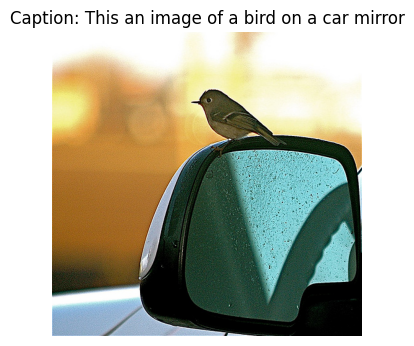

In [3]:
## Inspecting an image

import matplotlib.pyplot as plt 
from PIL import Image 


sample_img= ds[0]['image']

plt.figure(figsize=(4,4))
plt.imshow(sample_img)
plt.axis('off')
plt.title(f"Caption: {ds[0]['sentences']['raw']}")
plt.show()

#### 3. Standardizing the image file sizes

---

I've implemented this part locally in a separate notebook file. Link to the notebook: [Click here](Preprocess/preprocess.ipynb)

In [2]:
# Loading and inspecting
from datasets import load_from_disk

ds_pre = load_from_disk('/kaggle/input/preprocessed-train-images/Preprocessed_ds')

ds_pre

Loading dataset from disk:   0%|          | 0/90 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'],
    num_rows: 56674
})

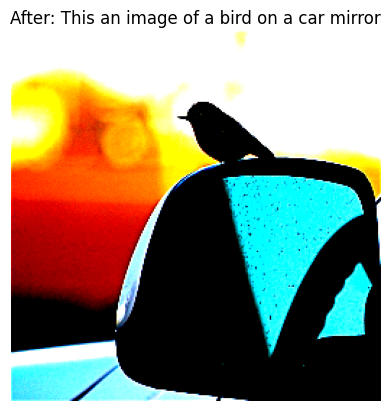

In [3]:
import matplotlib.pyplot as plt
import numpy as np


img = ds_pre[0]['image']


img = np.array(img)

# Ensure the dimensions are [Height, Width, Channels] (matplotlib format)
if img.shape[0] == 3:  # If in [Channels, Height, Width] format
    img = np.transpose(img, (1, 2, 0))

# Convert to uint8 if necessary
if img.max() <= 1.0:
    img = (img * 255).astype(np.uint8)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f"After: {ds_pre[0]['sentences']['raw']}")
plt.show()

Hence, the converted dataset is infact working!!

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch.nn.functional as F
from torchvision import transforms

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)

class PreprocessedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=16):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        import cv2
        cv2.setNumThreads(0)  # Fix OpenCV threading
        
        item = self.dataset[idx]
        image = torch.tensor(item['image'], dtype=torch.float32)
        caption = item['sentences']['raw']
        
        if image.shape[0] != 3:
            image = image.permute(2, 0, 1)
        image = (image - 0.5) / 0.5
        
        tokenized = self.tokenizer(
            caption, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_length,
            return_tensors='pt'
        )
        return image, tokenized.input_ids.squeeze(0)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### cDC-GAN implementation

---

In [4]:
## Necessary imports 
import torch
import os
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import gc 

In [2]:
## Configs:
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Model parameters
Z_DIM = 100
EMBED_DIM = 256
IMG_CHANNELS = 3
IMG_SIZE = 256

# Training parameters
MAX_EPOCHS = 5
BATCH_SIZE = 16
NUM_WORKERS = 2
CHANNELS_LAST = True
PREFETCH_FACTOR = 2
CHECKPOINT_INTERVAL = 1

In [3]:
## Real GAN Starts here:
class Generator(nn.Module):
    def __init__(self, z_dim, embed_dim, img_channels):
        super().__init__()
        self.img_size = IMG_SIZE
        
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.fc_embed = nn.Linear(embed_dim, z_dim)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim * 2, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, captions):
        embed = self.embedding(captions).mean(dim=1)
        embed = self.fc_embed(embed)
        combined = torch.cat([z, embed], dim=1)
        combined = combined.unsqueeze(-1).unsqueeze(-1)
        return self.main(combined)

class Discriminator(nn.Module):
    def __init__(self, embed_dim, img_channels):
        super().__init__()
        
        self.img_net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.fc_embed = nn.Linear(embed_dim, 1024)
        
        self.fc = nn.Linear(2048, 1)

    def forward(self, img, captions):
        img_feat = self.img_net(img).view(img.size(0), -1)
        embed = self.embedding(captions).mean(dim=1)
        embed = self.fc_embed(embed)
        combined = torch.cat([img_feat, embed], dim=1)
        return self.fc(combined)

In [4]:
## Initializing the models and utilizing the parallel GPUs if more than 1 GPU exits 
def initialize_models(device):
    generator = Generator(Z_DIM, EMBED_DIM, IMG_CHANNELS).to(device)
    discriminator = Discriminator(EMBED_DIM, IMG_CHANNELS).to(device)
    
    if CHANNELS_LAST and torch.cuda.is_available():
        generator = generator.to(memory_format=torch.channels_last)
        discriminator = discriminator.to(memory_format=torch.channels_last)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)
    
    return generator, discriminator

In [8]:
## Model training Function:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*40}\nTraining on {device}\n{'='*40}")

    generator, discriminator = initialize_models(device)
    
    opt_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    scaler = GradScaler(enabled=torch.cuda.is_available())

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    dataset = PreprocessedDataset(ds_pre, tokenizer)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,  # Now 0
        pin_memory=True,
        persistent_workers=False  # Disable persistent workers
    )

    try:
        for epoch in range(MAX_EPOCHS):
            generator.train()
            discriminator.train()
            
            progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{MAX_EPOCHS}]")
            
            for real_imgs, captions in progress_bar:
                real_imgs = real_imgs.to(device, non_blocking=True)
                captions = captions.to(device, non_blocking=True)

                # Train Discriminator
                opt_d.zero_grad(set_to_none=True)
                
                with autocast(enabled=torch.cuda.is_available()):
                    z = torch.randn(real_imgs.size(0), Z_DIM, device=device)
                    fake_imgs = generator(z, captions)
                    
                    real_pred = discriminator(real_imgs, captions)
                    fake_pred = discriminator(fake_imgs.detach(), captions)
                    
                    real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.full_like(real_pred, 0.9))
                    fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
                    d_loss = (real_loss + fake_loss) * 0.5

                scaler.scale(d_loss).backward()
                scaler.step(opt_d)
                
                # Train Generator
                opt_g.zero_grad(set_to_none=True)
                
                with autocast(enabled=torch.cuda.is_available()):
                    fake_pred = discriminator(fake_imgs, captions)
                    g_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))

                scaler.scale(g_loss).backward()
                scaler.step(opt_g)
                scaler.update()

                # Explicitly dereference tensors
                del real_imgs, captions, fake_imgs, z, real_pred, fake_pred
                torch.cuda.empty_cache()  # Clear GPU cache

                # Progress logging
                if torch.cuda.is_available():
                    mem = torch.cuda.max_memory_allocated() / 1e9
                    progress_bar.set_postfix({
                        'd_loss': f"{d_loss.item():.3f}",
                        'g_loss': f"{g_loss.item():.3f}",
                        'gpu_mem': f"{mem:.2f}GB"
                    })
                else:
                    progress_bar.set_postfix({
                        'd_loss': f"{d_loss.item():.3f}",
                        'g_loss': f"{g_loss.item():.3f}"
                    })

            # Force garbage collection after each epoch
            gc.collect()
            
            # Save checkpoint
            if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
                save_checkpoint(epoch, generator, discriminator, opt_g, opt_d, scaler)

    finally:
        torch.cuda.empty_cache()

def save_checkpoint(epoch, generator, discriminator, opt_g, opt_d, scaler):
    checkpoint = {
        'generator': generator.module.state_dict() if isinstance(generator, nn.DataParallel) else generator.state_dict(),
        'discriminator': discriminator.module.state_dict() if isinstance(discriminator, nn.DataParallel) else discriminator.state_dict(),
        'opt_g': opt_g.state_dict(),
        'opt_d': opt_d.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f"epoch_{epoch+1}.pt"))
    print(f"Saved checkpoint at epoch {epoch+1}")


In [9]:
if __name__ == '__main__':
    # Verify CUDA setup
    print(f"CUDA Available: {torch.cuda.is_available()}")
    print(f"Device Count: {torch.cuda.device_count()}")
    
    # Start training
    train_model()

CUDA Available: True
Device Count: 2

Training on cuda
Using 2 GPUs!


Epoch [1/5]: 100%|██████████| 3543/3543 [51:17<00:00,  1.15it/s, d_loss=0.226, g_loss=5.203, gpu_mem=0.92GB] 


Saved checkpoint at epoch 1


Epoch [2/5]: 100%|██████████| 3543/3543 [52:01<00:00,  1.14it/s, d_loss=0.170, g_loss=7.309, gpu_mem=0.92GB] 


Saved checkpoint at epoch 2


Epoch [3/5]: 100%|██████████| 3543/3543 [52:30<00:00,  1.12it/s, d_loss=0.164, g_loss=8.324, gpu_mem=0.92GB] 


Saved checkpoint at epoch 3


Epoch [4/5]:  32%|███▏      | 1144/3543 [16:36<34:50,  1.15it/s, d_loss=0.163, g_loss=8.824, gpu_mem=0.92GB] 


KeyboardInterrupt: 

I interrupted since I didn't want to wait any longer 🤷. Next, I'll be saving the checkpoints models on device...

In [18]:
!zip -r checkpoints.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/epoch_2.pt (deflated 27%)
  adding: kaggle/working/checkpoints/epoch_1.pt (deflated 27%)
  adding: kaggle/working/checkpoints/epoch_3.pt (deflated 27%)


Next, I'll try on my device itself...


---